# LitBank Named Entity Recognition with RNN (Adapted)

This notebook demonstrates:
1. Loading and exploring the LitBank dataset (with its actual nested structure)
2. Data preprocessing and flattening for NER
3. Building RNN models (Simple RNN, LSTM, BiLSTM)
4. Training and evaluation
5. Performance comparison and analysis

**Dataset**: LitBank - annotated literary texts with entity labels

**Note**: This version is adapted for LitBank's nested structure:
- `sentences`: List of sentences per document, each sentence is a list of tokens
- `entities`: List of entities per sentence, each entity has `token` and `bio_tags`

## 1. Setup and Imports

In [1]:
# Import PyTorch for deep learning
import torch  # Main PyTorch library
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import Dataset, DataLoader  # Data handling utilities

# Import scientific computing libraries
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis

# Import visualization libraries
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical visualizations

# Import machine learning utilities
from sklearn.model_selection import train_test_split  # Data splitting

# Import NER evaluation metrics (specialized for sequence labeling)
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

# Import standard Python libraries
from collections import Counter  # Count occurrences
from tqdm.auto import tqdm  # Progress bars
import os  # Operating system utilities
import json  # JSON file handling

# Set random seeds for reproducibility (ensures same results each run)
torch.manual_seed(42)  # PyTorch random seed
np.random.seed(42)  # NumPy random seed

# Check if GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, otherwise CPU
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")  # Print GPU name
    print(f"CUDA Version: {torch.version.cuda}")  # Print CUDA version

Using device: cpu


## 2. Load LitBank Dataset

LitBank is loaded from Hugging Face. It contains literary texts annotated with:
- Named entities (PER, LOC, FAC, GPE, VEH, ORG)
- Coreference chains
- Events

In [2]:
# Import the datasets library from Hugging Face
from datasets import load_dataset

# Load LitBank dataset from Hugging Face
try:
    # Load the dataset with split_0 configuration
    dataset = load_dataset("coref-data/litbank_raw", "split_0")
    print("LitBank dataset loaded successfully!")
    # Display the dataset structure (train/validation/test splits)
    print(f"Dataset structure: {dataset}")
except Exception as e:
    # If loading fails, print error message
    print(f"Error loading dataset: {e}")
    print("You may need to download LitBank manually from https://github.com/dbamman/litbank")

LitBank dataset loaded successfully!
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['doc_name', 'meta_info', 'sentences', 'coref_chains', 'entities', 'events', 'original_text', 'quotes'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['doc_name', 'meta_info', 'sentences', 'coref_chains', 'entities', 'events', 'original_text', 'quotes'],
        num_rows: 10
    })
    test: Dataset({
        features: ['doc_name', 'meta_info', 'sentences', 'coref_chains', 'entities', 'events', 'original_text', 'quotes'],
        num_rows: 10
    })
})


## 3. Understand Dataset Structure

LitBank has a nested structure. Let's explore it to understand how to process the data.

In [3]:
# Explore the first example in the training set
if 'train' in dataset and len(dataset['train']) > 0:
    # Get the first sample from training data
    sample = dataset['train'][0]
    
    # Print all available keys (fields) in the sample
    print("Available fields in each document:")
    print(list(sample.keys()))
    
    # Show the structure of sentences (nested list)
    print("\n" + "="*60)
    print("SENTENCES structure:")
    print(f"Number of sentences in first document: {len(sample['sentences'])}")
    print(f"First sentence tokens: {sample['sentences'][0]}")
    print(f"Second sentence tokens: {sample['sentences'][1]}")
    
    # Show the structure of entities (nested list with dicts)
    print("\n" + "="*60)
    print("ENTITIES structure:")
    print(f"Number of entity lists: {len(sample['entities'])}")
    print(f"Entities in first sentence: {sample['entities'][0][:5]}")  # Show first 5 entities
    
    # Explain the structure
    print("\n" + "="*60)
    print("STRUCTURE EXPLANATION:")
    print("- Each document contains multiple sentences")
    print("- sentences[i] = list of tokens in sentence i")
    print("- entities[i] = list of entity dicts for sentence i")
    print("- Each entity dict has: 'token' (word) and 'bio_tags' (NER labels)")
    print("- bio_tags can be: 'O' (not an entity) or 'B-TYPE', 'I-TYPE' (entity)")
else:
    print("No training data available")

Available fields in each document:
['doc_name', 'meta_info', 'sentences', 'coref_chains', 'entities', 'events', 'original_text', 'quotes']

SENTENCES structure:
Number of sentences in first document: 94
First sentence tokens: ['CHAPTER', '1', 'Loomings', 'Call', 'me', 'Ishmael', '.']
Second sentence tokens: ['Some', 'years', 'ago', '--', 'never', 'mind', 'how', 'long', 'precisely', '--', 'having', 'little', 'or', 'no', 'money', 'in', 'my', 'purse', ',', 'and', 'nothing', 'particular', 'to', 'interest', 'me', 'on', 'shore', ',', 'I', 'thought', 'I', 'would', 'sail', 'about', 'a', 'little', 'and', 'see', 'the', 'watery', 'part', 'of', 'the', 'world', '.']

ENTITIES structure:
Number of entity lists: 94
Entities in first sentence: [{'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': 'CHAPTER'}, {'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': '1'}, {'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': 'Loomings'}, {'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': 'Call'}, {'bio_tags': ['O', 'O', 'O', 

## 4. Flatten Dataset Structure

The model needs flat lists of tokens and tags. We'll create a function to convert LitBank's nested structure into sentence-level examples.

In [4]:
def flatten_litbank_data(dataset_split):
    """
    Convert LitBank's nested structure to flat sentence-level examples.
    
    Input: Dataset with nested sentences and entities per document
    Output: List of dicts with 'tokens' and 'ner_tags' per sentence
    """
    flattened_examples = []  # Store all flattened sentences here
    
    # Loop through each document in the dataset
    for doc_idx, example in enumerate(dataset_split):
        # Get all sentences in this document (list of token lists)
        sentences = example.get('sentences', [])
        # Get all entities in this document (list of entity lists per sentence)
        entities = example.get('entities', [])
        
        # Process each sentence in the document
        for sent_idx, sentence_tokens in enumerate(sentences):
            # Skip empty sentences
            if not sentence_tokens:
                continue
            
            # Get entities for this specific sentence
            # Entities are aligned with sentences (entities[i] corresponds to sentences[i])
            sent_entities = entities[sent_idx] if sent_idx < len(entities) else []
            
            # Create a mapping from token to its NER tag
            # Each token in sentence_tokens needs a corresponding tag
            token_to_tag = {}  # Dictionary: token_index -> NER tag
            
            # Process each entity in this sentence
            for entity_dict in sent_entities:
                # Each entity has 'token' (the word) and 'bio_tags' (its NER label)
                token = entity_dict.get('token', '')
                bio_tags = entity_dict.get('bio_tags', [])
                
                # bio_tags can be a list (for multi-word entities) or single string
                if isinstance(bio_tags, list) and len(bio_tags) > 0:
                    # Take the first tag if it's a list
                    tag = bio_tags[0] if bio_tags[0] else 'O'
                elif isinstance(bio_tags, str):
                    # Use the tag directly if it's a string
                    tag = bio_tags if bio_tags else 'O'
                else:
                    # Default to 'O' (outside entity) if no tag
                    tag = 'O'
                
                # Find this token in the sentence and record its tag
                # We search for the token's position to align it
                for token_idx, sent_token in enumerate(sentence_tokens):
                    # If token matches and hasn't been tagged yet
                    if sent_token == token and token_idx not in token_to_tag:
                        token_to_tag[token_idx] = tag
                        break  # Found it, move to next entity
            
            # Create the final list of tags aligned with tokens
            # Any token not in token_to_tag gets 'O' (outside entity)
            ner_tags = [token_to_tag.get(i, 'O') for i in range(len(sentence_tokens))]
            
            # Add this sentence as a flat example
            flattened_examples.append({
                'tokens': sentence_tokens,  # List of words
                'ner_tags': ner_tags,  # List of NER labels (same length)
                'doc_idx': doc_idx,  # Track which document it came from
                'sent_idx': sent_idx  # Track which sentence in the document
            })
    
    return flattened_examples

# Flatten all dataset splits
print("Flattening dataset...")
train_data = flatten_litbank_data(dataset['train'])  # Flatten training data
val_data = flatten_litbank_data(dataset['validation'])  # Flatten validation data
test_data = flatten_litbank_data(dataset['test'])  # Flatten test data

# Print statistics
print(f"\nFlattened data statistics:")
print(f"Training sentences: {len(train_data)}")
print(f"Validation sentences: {len(val_data)}")
print(f"Test sentences: {len(test_data)}")

# Show an example
print(f"\nExample sentence:")
print(f"Tokens: {train_data[0]['tokens'][:15]}...")  # First 15 tokens
print(f"Tags:   {train_data[0]['ner_tags'][:15]}...")  # Corresponding tags

Flattening dataset...

Flattened data statistics:
Training sentences: 6755
Validation sentences: 927
Test sentences: 880

Example sentence:
Tokens: ['CHAPTER', '1', 'Loomings', 'Call', 'me', 'Ishmael', '.']...
Tags:   ['O', 'O', 'O', 'O', 'O', 'B-PER', 'O']...


## 5. Analyze NER Tag Distribution

Let's see what types of entities appear in LitBank and how frequently.


NER Tag Distribution:
B-FAC          :   1513 occurrences ( 0.89%)
B-GPE          :    675 occurrences ( 0.40%)
B-LOC          :    838 occurrences ( 0.49%)
B-ORG          :     88 occurrences ( 0.05%)
B-PER          :   6383 occurrences ( 3.77%)
B-VEH          :    163 occurrences ( 0.10%)
I-FAC          :   2237 occurrences ( 1.32%)
I-GPE          :    467 occurrences ( 0.28%)
I-LOC          :   1383 occurrences ( 0.82%)
I-ORG          :    172 occurrences ( 0.10%)
I-PER          :   9066 occurrences ( 5.35%)
I-VEH          :    241 occurrences ( 0.14%)
O              : 146230 occurrences (86.29%)


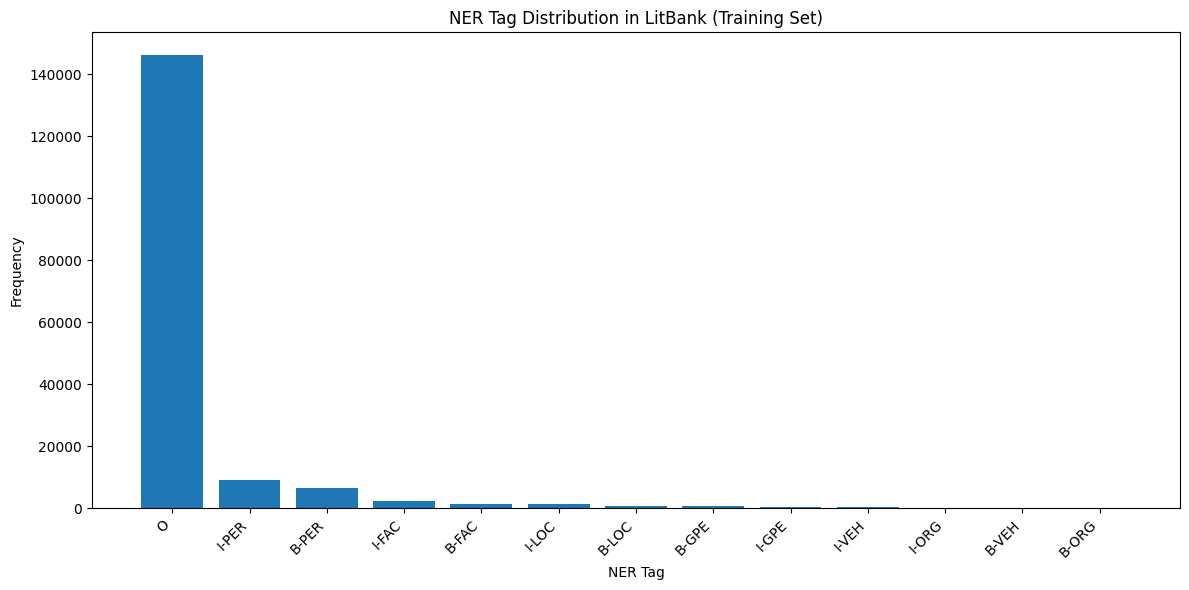


Entity Tags Only (excluding 'O'):


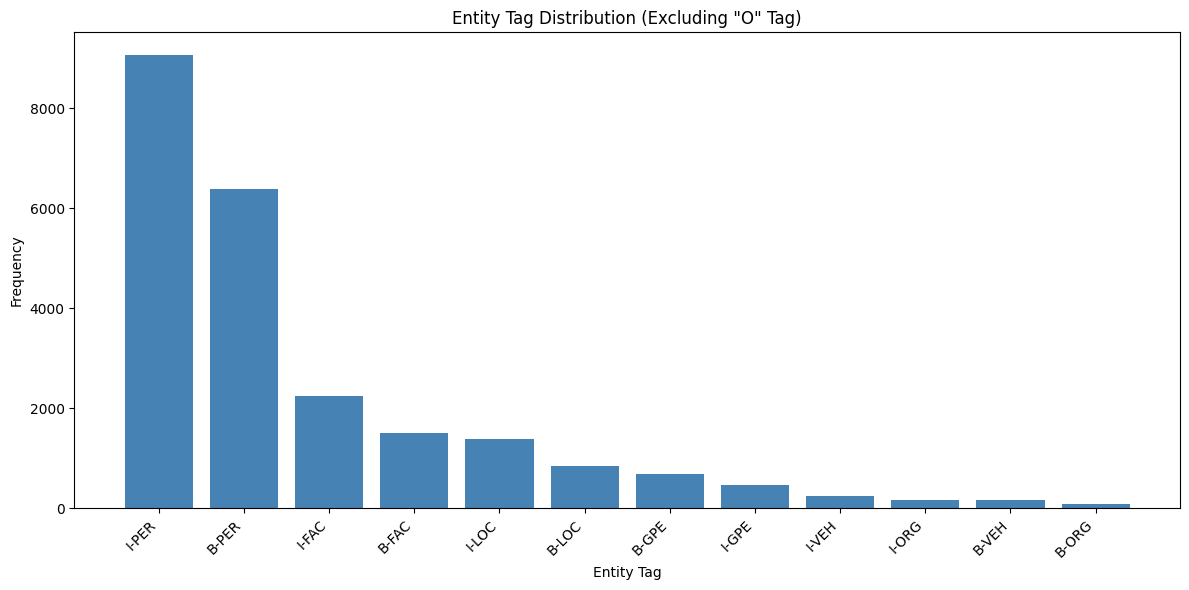

In [5]:
# Count all NER tags in the training data
def get_tag_distribution(flattened_data):
    """Count how many times each NER tag appears."""
    all_tags = []  # Collect all tags
    
    # Loop through each sentence
    for example in flattened_data:
        # Add all tags from this sentence to our list
        all_tags.extend(example['ner_tags'])
    
    # Count occurrences of each tag
    return Counter(all_tags)

# Get tag distribution from training data
tag_dist = get_tag_distribution(train_data)

# Print the distribution
print("\nNER Tag Distribution:")
for tag, count in sorted(tag_dist.items()):
    # Calculate percentage
    percentage = (count / sum(tag_dist.values())) * 100
    print(f"{tag:15s}: {count:6d} occurrences ({percentage:5.2f}%)")

# Visualize the distribution
plt.figure(figsize=(12, 6))
# Sort tags by count for better visualization
sorted_tags = sorted(tag_dist.items(), key=lambda x: x[1], reverse=True)
tags, counts = zip(*sorted_tags)
# Create bar plot
plt.bar(range(len(tags)), counts)
plt.xticks(range(len(tags)), tags, rotation=45, ha='right')
plt.xlabel('NER Tag')
plt.ylabel('Frequency')
plt.title('NER Tag Distribution in LitBank (Training Set)')
plt.tight_layout()
plt.show()

# Also show distribution without 'O' tag for better visibility of entities
entity_tags = {tag: count for tag, count in tag_dist.items() if tag != 'O'}
if entity_tags:
    print("\nEntity Tags Only (excluding 'O'):")
    plt.figure(figsize=(12, 6))
    sorted_entity_tags = sorted(entity_tags.items(), key=lambda x: x[1], reverse=True)
    tags, counts = zip(*sorted_entity_tags)
    plt.bar(range(len(tags)), counts, color='steelblue')
    plt.xticks(range(len(tags)), tags, rotation=45, ha='right')
    plt.xlabel('Entity Tag')
    plt.ylabel('Frequency')
    plt.title('Entity Tag Distribution (Excluding "O" Tag)')
    plt.tight_layout()
    plt.show()

## 6. Create Tag Mappings

Neural networks work with numbers, not text. We need to convert:
- Tag names (like "B-PER") → numbers (like 0, 1, 2...)
- Numbers → tag names (for interpreting predictions)

In [6]:
# Extract all unique tags from the training data
all_tags = set()  # Use set to get unique values only
for example in train_data:
    # Add all tags from this sentence to the set
    all_tags.update(example['ner_tags'])

# Convert to sorted list (put 'O' first, then alphabetical)
# 'O' should be index 0 because we'll use it for padding
tag_names = sorted(all_tags, key=lambda x: (x != 'O', x))

# Create mapping: tag name → number (for converting labels to model input)
tag2idx = {tag: idx for idx, tag in enumerate(tag_names)}

# Create reverse mapping: number → tag name (for converting predictions to readable tags)
idx2tag = {idx: tag for idx, tag in enumerate(tag_names)}

# Print the mappings
print("Tag to Index Mapping:")
for tag, idx in tag2idx.items():
    print(f"  {tag:15s} → {idx}")

print(f"\nTotal unique tags: {len(tag_names)}")

Tag to Index Mapping:
  O               → 0
  B-FAC           → 1
  B-GPE           → 2
  B-LOC           → 3
  B-ORG           → 4
  B-PER           → 5
  B-VEH           → 6
  I-FAC           → 7
  I-GPE           → 8
  I-LOC           → 9
  I-ORG           → 10
  I-PER           → 11
  I-VEH           → 12

Total unique tags: 13


## 7. Analyze Sentence Lengths

Understanding sentence length distribution helps us choose the right maximum sequence length for the model.

Sentence Length Statistics:
  Mean:   25.09 tokens
  Median: 20 tokens
  Std:    20.49 tokens
  Min:    1 tokens
  Max:    307 tokens

Percentiles:
  50th percentile: 20 tokens
  75th percentile: 33 tokens
  90th percentile: 50 tokens
  95th percentile: 62 tokens
  99th percentile: 97 tokens


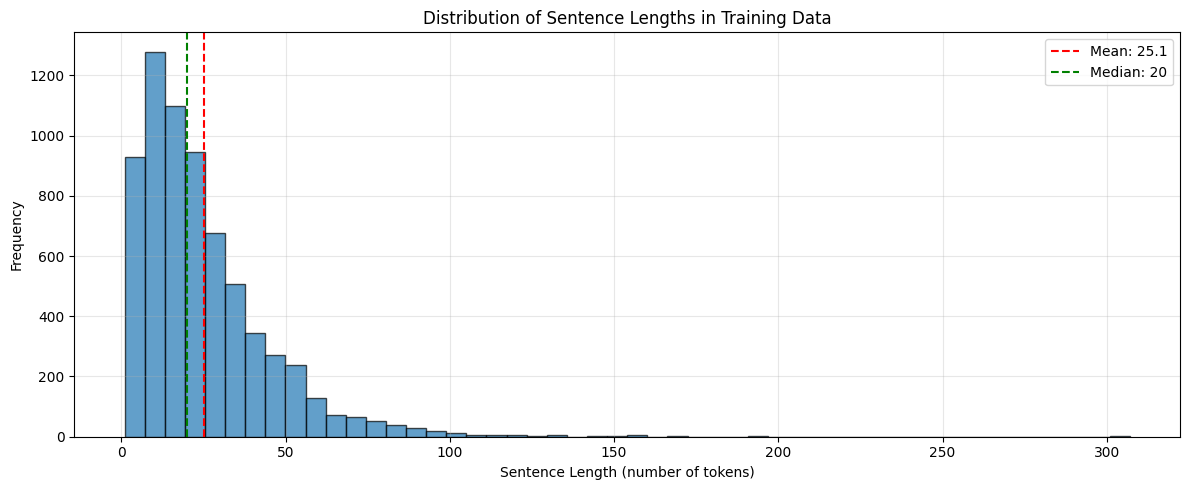


Recommended MAX_LEN: 62 (covers 95% of sentences)


In [7]:
# Calculate length of each sentence (number of tokens)
sentence_lengths = [len(example['tokens']) for example in train_data]

# Calculate statistics
print(f"Sentence Length Statistics:")
print(f"  Mean:   {np.mean(sentence_lengths):.2f} tokens")
print(f"  Median: {np.median(sentence_lengths):.0f} tokens")
print(f"  Std:    {np.std(sentence_lengths):.2f} tokens")
print(f"  Min:    {np.min(sentence_lengths)} tokens")
print(f"  Max:    {np.max(sentence_lengths)} tokens")

# Calculate percentiles to help choose max_len
percentiles = [50, 75, 90, 95, 99]
print(f"\nPercentiles:")
for p in percentiles:
    value = np.percentile(sentence_lengths, p)
    print(f"  {p}th percentile: {value:.0f} tokens")

# Visualize the distribution
plt.figure(figsize=(12, 5))
plt.hist(sentence_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(sentence_lengths), color='red', linestyle='--', 
            label=f'Mean: {np.mean(sentence_lengths):.1f}')
plt.axvline(np.median(sentence_lengths), color='green', linestyle='--', 
            label=f'Median: {np.median(sentence_lengths):.0f}')
plt.xlabel('Sentence Length (number of tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths in Training Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Suggest a good max_len value
recommended_max_len = int(np.percentile(sentence_lengths, 95))
print(f"\nRecommended MAX_LEN: {recommended_max_len} (covers 95% of sentences)")

## 8. Build Vocabulary

Create a vocabulary of all words in the training data. Each word gets a unique number.

In [8]:
def build_vocab(flattened_data, min_freq=2):
    """
    Build vocabulary from training data.
    
    Args:
        flattened_data: List of sentence dicts with 'tokens'
        min_freq: Minimum frequency for a word to be included (default=2)
                  Words appearing less than this become <UNK> (unknown)
    
    Returns:
        word2idx: Dictionary mapping words to indices
        vocab: List of all words in vocabulary
    """
    # Count how many times each word appears
    word_freq = Counter()
    for example in flattened_data:
        # Convert to lowercase for case-insensitive vocabulary
        word_freq.update([token.lower() for token in example['tokens']])
    
    # Build vocabulary: special tokens first, then frequent words
    # <PAD>: Padding token (index 0) - used to make all sequences same length
    # <UNK>: Unknown token (index 1) - used for words not in vocabulary
    vocab = ['<PAD>', '<UNK>']
    
    # Add words that appear at least min_freq times
    vocab.extend([word for word, freq in word_freq.items() if freq >= min_freq])
    
    # Create mapping: word → index
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    
    # Print statistics
    print(f"Total unique words (before filtering): {len(word_freq)}")
    print(f"Vocabulary size (min_freq={min_freq}): {len(vocab)}")
    print(f"Words filtered out: {len(word_freq) - (len(vocab) - 2)}")
    
    return word2idx, vocab

# Build vocabulary from training data
word2idx, vocab = build_vocab(train_data, min_freq=2)

# Show some example words from vocabulary
print(f"\nSample vocabulary words: {vocab[2:22]}")  # Skip <PAD> and <UNK>
print(f"\nSpecial tokens:")
print(f"  <PAD> index: {word2idx['<PAD>']}")
print(f"  <UNK> index: {word2idx['<UNK>']}")

Total unique words (before filtering): 14735
Vocabulary size (min_freq=2): 7265
Words filtered out: 7472

Sample vocabulary words: ['chapter', '1', 'call', 'me', '.', 'some', 'years', 'ago', '--', 'never', 'mind', 'how', 'long', 'precisely', 'having', 'little', 'or', 'no', 'money', 'in']

Special tokens:
  <PAD> index: 0
  <UNK> index: 1


## 9. Create PyTorch Dataset Class

This class handles:
- Converting words to numbers
- Converting tags to numbers
- Padding sequences to the same length
- Creating attention masks (to ignore padding)

In [9]:
class NERDataset(Dataset):
    """
    Custom PyTorch Dataset for Named Entity Recognition.
    
    Converts tokens and tags to numerical format and handles padding.
    """
    
    def __init__(self, data, word2idx, tag2idx, max_len=128):
        """
        Args:
            data: List of dicts with 'tokens' and 'ner_tags'
            word2idx: Dictionary mapping words to indices
            tag2idx: Dictionary mapping tags to indices
            max_len: Maximum sequence length (longer sequences are truncated)
        """
        self.data = data  # Store the data
        self.word2idx = word2idx  # Store word mappings
        self.tag2idx = tag2idx  # Store tag mappings
        self.max_len = max_len  # Store max length
    
    def __len__(self):
        """Return the number of examples in the dataset."""
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Get a single example from the dataset.
        
        Returns:
            Dictionary with:
                - input_ids: Token indices (padded to max_len)
                - labels: Tag indices (padded to max_len)
                - attention_mask: 1 for real tokens, 0 for padding
        """
        # Get the example at this index
        example = self.data[idx]
        tokens = example['tokens']  # List of words
        tags = example['ner_tags']  # List of NER tags
        
        # Convert tokens to indices
        # Use <UNK> index for words not in vocabulary
        token_ids = [
            self.word2idx.get(token.lower(), self.word2idx['<UNK>']) 
            for token in tokens
        ]
        
        # Convert tags to indices
        tag_ids = [self.tag2idx[tag] for tag in tags]
        
        # Truncate or pad to max_len
        if len(token_ids) > self.max_len:
            # Sequence too long: truncate
            token_ids = token_ids[:self.max_len]
            tag_ids = tag_ids[:self.max_len]
        else:
            # Sequence too short: pad with <PAD> (index 0)
            padding_len = self.max_len - len(token_ids)
            token_ids = token_ids + [self.word2idx['<PAD>']] * padding_len
            tag_ids = tag_ids + [0] * padding_len  # Pad tags with 0 (usually 'O')
        
        # Create attention mask: 1 for real tokens, 0 for padding
        # The model will ignore positions with 0 in the mask
        attention_mask = [
            1 if tid != self.word2idx['<PAD>'] else 0 
            for tid in token_ids
        ]
        
        # Return as PyTorch tensors
        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),  # Token indices
            'labels': torch.tensor(tag_ids, dtype=torch.long),  # Tag indices
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long)  # Mask
        }

# Set hyperparameters
MAX_LEN = 128  # Maximum sequence length
BATCH_SIZE = 16  # Number of examples per batch (reduced for small dataset)

# Create dataset objects
train_dataset = NERDataset(train_data, word2idx, tag2idx, MAX_LEN)
val_dataset = NERDataset(val_data, word2idx, tag2idx, MAX_LEN)
test_dataset = NERDataset(test_data, word2idx, tag2idx, MAX_LEN)

# Create data loaders (handle batching and shuffling)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True  # Shuffle training data each epoch
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False  # Don't shuffle validation data
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False  # Don't shuffle test data
)

# Print dataset sizes
print(f"Dataset sizes:")
print(f"  Training:   {len(train_dataset):4d} sentences, {len(train_loader):3d} batches")
print(f"  Validation: {len(val_dataset):4d} sentences, {len(val_loader):3d} batches")
print(f"  Test:       {len(test_dataset):4d} sentences, {len(test_loader):3d} batches")

# Test: Get one batch and show its shape
sample_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"  input_ids:      {sample_batch['input_ids'].shape}  (batch_size, max_len)")
print(f"  labels:         {sample_batch['labels'].shape}  (batch_size, max_len)")
print(f"  attention_mask: {sample_batch['attention_mask'].shape}  (batch_size, max_len)")

Dataset sizes:
  Training:   6755 sentences, 423 batches
  Validation:  927 sentences,  58 batches
  Test:        880 sentences,  55 batches

Sample batch shapes:
  input_ids:      torch.Size([16, 128])  (batch_size, max_len)
  labels:         torch.Size([16, 128])  (batch_size, max_len)
  attention_mask: torch.Size([16, 128])  (batch_size, max_len)


## 10. Define RNN Model Architecture

This model has:
1. **Embedding layer**: Converts word indices to dense vectors
2. **RNN layer**: Processes the sequence (can be RNN, LSTM, or GRU)
3. **Classification layer**: Predicts NER tag for each token

In [10]:
class RNNTagger(nn.Module):
    """
    RNN-based sequence labeling model for NER.
    
    Architecture:
        Input (token ids) → Embedding → RNN → Dropout → Linear → Output (tag logits)
    """
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags, 
                 rnn_type='lstm', bidirectional=False, num_layers=1, dropout=0.3):
        """
        Args:
            vocab_size: Size of word vocabulary
            embedding_dim: Dimension of word embeddings
            hidden_dim: Dimension of RNN hidden state
            num_tags: Number of NER tags (output classes)
            rnn_type: Type of RNN ('rnn', 'lstm', or 'gru')
            bidirectional: If True, process sequence in both directions
            num_layers: Number of stacked RNN layers
            dropout: Dropout probability for regularization
        """
        super(RNNTagger, self).__init__()
        
        # Embedding layer: Converts word indices to dense vectors
        # padding_idx=0 means the padding token (index 0) has zero embedding
        self.embedding = nn.Embedding(
            vocab_size,      # Number of words
            embedding_dim,   # Size of embedding vector for each word
            padding_idx=0    # Padding token index
        )
        
        # Dropout for regularization (prevents overfitting)
        self.dropout = nn.Dropout(dropout)
        
        # Select RNN type
        if rnn_type.lower() == 'rnn':
            # Simple RNN (vanilla RNN)
            self.rnn = nn.RNN(
                embedding_dim,    # Input size
                hidden_dim,       # Hidden state size
                num_layers=num_layers,  # Stack multiple RNN layers
                bidirectional=bidirectional,  # Process both directions
                batch_first=True,  # Input shape: (batch, seq_len, features)
                dropout=dropout if num_layers > 1 else 0  # Dropout between layers
            )
        elif rnn_type.lower() == 'lstm':
            # LSTM (Long Short-Term Memory) - better at long-range dependencies
            self.rnn = nn.LSTM(
                embedding_dim,
                hidden_dim,
                num_layers=num_layers,
                bidirectional=bidirectional,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0
            )
        elif rnn_type.lower() == 'gru':
            # GRU (Gated Recurrent Unit) - simpler than LSTM, similar performance
            self.rnn = nn.GRU(
                embedding_dim,
                hidden_dim,
                num_layers=num_layers,
                bidirectional=bidirectional,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0
            )
        else:
            raise ValueError(f"Unknown RNN type: {rnn_type}")
        
        # Output layer: Maps RNN output to tag scores
        # If bidirectional, hidden_dim is doubled (forward + backward)
        rnn_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(rnn_output_dim, num_tags)
    
    def forward(self, input_ids, attention_mask=None):
        """
        Forward pass through the model.
        
        Args:
            input_ids: Token indices, shape (batch_size, seq_len)
            attention_mask: Mask for padding, shape (batch_size, seq_len)
        
        Returns:
            logits: Tag scores for each token, shape (batch_size, seq_len, num_tags)
        """
        # Step 1: Convert token indices to embeddings
        # Shape: (batch_size, seq_len) → (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(input_ids)
        embedded = self.dropout(embedded)  # Apply dropout
        
        # Step 2: Process sequence with RNN
        # Shape: (batch_size, seq_len, embedding_dim) → (batch_size, seq_len, hidden_dim)
        rnn_out, _ = self.rnn(embedded)
        rnn_out = self.dropout(rnn_out)  # Apply dropout
        
        # Step 3: Predict tag for each token
        # Shape: (batch_size, seq_len, hidden_dim) → (batch_size, seq_len, num_tags)
        logits = self.fc(rnn_out)
        
        return logits

## 11. Initialize Models

We'll train three different models to compare:
1. **Simple RNN**: Vanilla RNN
2. **LSTM**: Better at long-range dependencies
3. **BiLSTM**: Processes sequence in both directions (best performance)

In [11]:
# Model hyperparameters
EMBEDDING_DIM = 100  # Size of word embedding vectors
HIDDEN_DIM = 128     # Size of RNN hidden state
NUM_LAYERS = 2       # Number of stacked RNN layers
DROPOUT = 0.3        # Dropout probability
NUM_TAGS = len(tag_names)    # Number of output classes (NER tags)
VOCAB_SIZE = len(vocab)      # Size of vocabulary

# Create three models with different architectures
models = {
    # 1. Simple RNN: Unidirectional vanilla RNN
    'SimpleRNN': RNNTagger(
        VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_TAGS,
        rnn_type='rnn',           # Use simple RNN
        bidirectional=False,      # One direction only
        num_layers=NUM_LAYERS,
        dropout=DROPOUT
    ),
    
    # 2. LSTM: Long Short-Term Memory (better at long-range dependencies)
    'LSTM': RNNTagger(
        VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_TAGS,
        rnn_type='lstm',          # Use LSTM
        bidirectional=False,      # One direction only
        num_layers=NUM_LAYERS,
        dropout=DROPOUT
    ),
    
    # 3. BiLSTM: Bidirectional LSTM (processes sequence both ways)
    'BiLSTM': RNNTagger(
        VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_TAGS,
        rnn_type='lstm',          # Use LSTM
        bidirectional=True,       # Both directions (forward and backward)
        num_layers=NUM_LAYERS,
        dropout=DROPOUT
    )
}

# Print model information
print("Model Architectures:\n")
for name, model in models.items():
    # Count total parameters
    total_params = sum(p.numel() for p in model.parameters())
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"{name:12s}:")
    print(f"  Total parameters:     {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print()

Model Architectures:

SimpleRNN   :
  Total parameters:     790,641
  Trainable parameters: 790,641

LSTM        :
  Total parameters:     978,033
  Trainable parameters: 978,033

BiLSTM      :
  Total parameters:     1,360,625
  Trainable parameters: 1,360,625



## 12. Training and Evaluation Functions

These functions handle:
- Training loop (forward pass, loss calculation, backward pass)
- Evaluation (calculate metrics: F1, precision, recall)

In [12]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """
    Train the model for one epoch.
    
    Returns:
        Average loss for this epoch
    """
    model.train()  # Set model to training mode (enables dropout, etc.)
    total_loss = 0  # Accumulate loss over all batches
    
    # Loop through batches with progress bar
    for batch in tqdm(dataloader, desc='Training'):
        # Move batch to device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)        # Token indices
        labels = batch['labels'].to(device)              # True NER tags
        attention_mask = batch['attention_mask'].to(device)  # Padding mask
        
        # Reset gradients from previous step
        optimizer.zero_grad()
        
        # Forward pass: Get predictions from model
        logits = model(input_ids, attention_mask)
        
        # Reshape for loss calculation
        # From: (batch_size, seq_len, num_tags)
        # To:   (batch_size * seq_len, num_tags)
        logits = logits.view(-1, logits.shape[-1])
        labels = labels.view(-1)  # Flatten labels too
        
        # Calculate loss (how wrong are the predictions?)
        loss = criterion(logits, labels)
        
        # Backward pass: Calculate gradients
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()
    
    # Return average loss over all batches
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device, idx2tag):
    """
    Evaluate the model on validation/test data.
    
    Returns:
        avg_loss: Average loss
        f1: F1 score (harmonic mean of precision and recall)
        precision: Precision score
        recall: Recall score
        predictions: List of predicted tag sequences
        true_labels: List of true tag sequences
    """
    model.eval()  # Set model to evaluation mode (disables dropout, etc.)
    total_loss = 0
    predictions = []  # Store all predictions
    true_labels = []  # Store all true labels
    
    # Disable gradient calculation (saves memory and computation)
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Forward pass
            logits = model(input_ids, attention_mask)
            
            # Calculate loss
            logits_flat = logits.view(-1, logits.shape[-1])
            labels_flat = labels.view(-1)
            loss = criterion(logits_flat, labels_flat)
            total_loss += loss.item()
            
            # Get predictions: Choose tag with highest score for each token
            preds = torch.argmax(logits, dim=-1)  # Shape: (batch_size, seq_len)
            
            # Convert predictions and labels to tag names
            # Only include non-padded tokens (attention_mask == 1)
            for i in range(len(preds)):
                pred_tags = []  # Predicted tags for this sequence
                true_tags = []  # True tags for this sequence
                
                # Loop through each token in the sequence
                for j in range(len(preds[i])):
                    if attention_mask[i][j] == 1:  # Not padding
                        # Convert index to tag name
                        pred_tags.append(idx2tag.get(preds[i][j].item(), 'O'))
                        true_tags.append(idx2tag.get(labels[i][j].item(), 'O'))
                
                # Only add non-empty sequences
                if pred_tags:
                    predictions.append(pred_tags)
                    true_labels.append(true_tags)
    
    # Calculate average loss
    avg_loss = total_loss / len(dataloader)
    
    # Calculate NER metrics using seqeval
    # These metrics properly handle multi-token entities (B-PER, I-PER)
    f1 = f1_score(true_labels, predictions)           # F1 score
    precision = precision_score(true_labels, predictions)  # Precision
    recall = recall_score(true_labels, predictions)        # Recall
    
    return avg_loss, f1, precision, recall, predictions, true_labels

## 13. Training Loop

Train all three models and save the best version of each.

In [13]:
def train_model(model, train_loader, val_loader, model_name, 
                num_epochs=15, learning_rate=0.001):
    """
    Train a model for multiple epochs and save the best version.
    
    Args:
        model: The RNN model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        model_name: Name for saving the model
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
    
    Returns:
        history: Dictionary with training metrics per epoch
        best_f1: Best F1 score achieved
    """
    # Move model to device (GPU or CPU)
    model = model.to(device)
    
    # Loss function: Cross Entropy Loss
    # ignore_index=0 means ignore padding tokens (index 0) in loss calculation
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Optimizer: Adam (adaptive learning rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Track metrics over epochs
    history = {
        'train_loss': [],      # Training loss per epoch
        'val_loss': [],        # Validation loss per epoch
        'val_f1': [],          # Validation F1 score per epoch
        'val_precision': [],   # Validation precision per epoch
        'val_recall': []       # Validation recall per epoch
    }
    
    best_f1 = 0  # Track best F1 score for model saving
    
    print(f"\nTraining {model_name}...")
    print("=" * 60)
    
    # Train for num_epochs epochs
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        history['train_loss'].append(train_loss)
        
        # Evaluation phase
        val_loss, val_f1, val_precision, val_recall, _, _ = evaluate(
            model, val_loader, criterion, device, idx2tag
        )
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        
        # Print metrics for this epoch
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f} | F1: {val_f1:.4f} | "
              f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f}")
        
        # Save best model (based on F1 score)
        if val_f1 > best_f1:
            best_f1 = val_f1
            # Create results directory if it doesn't exist
            os.makedirs('../results', exist_ok=True)
            # Save model weights
            torch.save(model.state_dict(), f'../results/{model_name}_best.pt')
            print(f"✓ New best model saved! F1: {best_f1:.4f}")
    
    print(f"\nTraining completed! Best F1: {best_f1:.4f}")
    return history, best_f1

# Training configuration
NUM_EPOCHS = 15        # Number of epochs to train
LEARNING_RATE = 0.001  # Learning rate for Adam optimizer

# Store results for all models
training_results = {}

# Train each model
for model_name, model in models.items():
    # Train the model
    history, best_f1 = train_model(
        model, train_loader, val_loader, model_name, NUM_EPOCHS, LEARNING_RATE
    )
    
    # Store results
    training_results[model_name] = {
        'history': history,     # Training metrics per epoch
        'best_f1': best_f1,     # Best F1 score
        'model': model          # The trained model
    }
    
    print("\n" + "="*60 + "\n")


Training SimpleRNN...

Epoch 1/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.4418
Val Loss: 1.1103 | F1: 0.0233 | Precision: 0.0130 | Recall: 0.1085
✓ New best model saved! F1: 0.0233

Epoch 2/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.2426
Val Loss: 1.0486 | F1: 0.0220 | Precision: 0.0125 | Recall: 0.0929

Epoch 3/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.1255
Val Loss: 1.0016 | F1: 0.0194 | Precision: 0.0109 | Recall: 0.0863

Epoch 4/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.0554
Val Loss: 0.9918 | F1: 0.0193 | Precision: 0.0107 | Recall: 0.0994

Epoch 5/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.9949
Val Loss: 0.9176 | F1: 0.0182 | Precision: 0.0103 | Recall: 0.0805

Epoch 6/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.9216
Val Loss: 0.9609 | F1: 0.0177 | Precision: 0.0100 | Recall: 0.0781

Epoch 7/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.8743
Val Loss: 0.9059 | F1: 0.0173 | Precision: 0.0097 | Recall: 0.0772

Epoch 8/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.8338
Val Loss: 0.8518 | F1: 0.0157 | Precision: 0.0089 | Recall: 0.0698

Epoch 9/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: nan
Val Loss: 0.9226 | F1: 0.0137 | Precision: 0.0078 | Recall: 0.0575

Epoch 10/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.7577
Val Loss: 0.9012 | F1: 0.0142 | Precision: 0.0081 | Recall: 0.0592

Epoch 11/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.7289
Val Loss: 0.9404 | F1: 0.0130 | Precision: 0.0075 | Recall: 0.0468

Epoch 12/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.7172
Val Loss: 0.8200 | F1: 0.0174 | Precision: 0.0098 | Recall: 0.0772

Epoch 13/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.6848
Val Loss: 0.8594 | F1: 0.0172 | Precision: 0.0096 | Recall: 0.0846

Epoch 14/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.6628
Val Loss: 0.8492 | F1: 0.0166 | Precision: 0.0094 | Recall: 0.0698

Epoch 15/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.6343
Val Loss: 0.8752 | F1: 0.0169 | Precision: 0.0095 | Recall: 0.0731

Training completed! Best F1: 0.0233



Training LSTM...

Epoch 1/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.5006
Val Loss: 1.1641 | F1: 0.0081 | Precision: 0.0047 | Recall: 0.0279
✓ New best model saved! F1: 0.0081

Epoch 2/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.1744
Val Loss: 1.0151 | F1: 0.0138 | Precision: 0.0078 | Recall: 0.0575
✓ New best model saved! F1: 0.0138

Epoch 3/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.0328
Val Loss: 0.9367 | F1: 0.0118 | Precision: 0.0067 | Recall: 0.0477

Epoch 4/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.9410
Val Loss: 0.9441 | F1: 0.0143 | Precision: 0.0081 | Recall: 0.0608
✓ New best model saved! F1: 0.0143

Epoch 5/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.8672
Val Loss: 0.8888 | F1: 0.0151 | Precision: 0.0085 | Recall: 0.0657
✓ New best model saved! F1: 0.0151

Epoch 6/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.7978
Val Loss: 0.8741 | F1: 0.0149 | Precision: 0.0084 | Recall: 0.0682

Epoch 7/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.7290
Val Loss: 0.8849 | F1: 0.0159 | Precision: 0.0090 | Recall: 0.0682
✓ New best model saved! F1: 0.0159

Epoch 8/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.6725
Val Loss: 0.8973 | F1: 0.0146 | Precision: 0.0083 | Recall: 0.0624

Epoch 9/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: nan
Val Loss: 0.8719 | F1: 0.0190 | Precision: 0.0106 | Recall: 0.0904
✓ New best model saved! F1: 0.0190

Epoch 10/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.5937
Val Loss: 0.9156 | F1: 0.0135 | Precision: 0.0076 | Recall: 0.0592

Epoch 11/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.5513
Val Loss: 0.9000 | F1: 0.0160 | Precision: 0.0090 | Recall: 0.0707

Epoch 12/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.5310
Val Loss: 0.9197 | F1: 0.0154 | Precision: 0.0087 | Recall: 0.0707

Epoch 13/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.4888
Val Loss: 0.9466 | F1: 0.0146 | Precision: 0.0082 | Recall: 0.0649

Epoch 14/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.4695
Val Loss: 0.9241 | F1: 0.0171 | Precision: 0.0096 | Recall: 0.0789

Epoch 15/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.4435
Val Loss: 0.9283 | F1: 0.0175 | Precision: 0.0098 | Recall: 0.0822

Training completed! Best F1: 0.0190



Training BiLSTM...

Epoch 1/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.4105
Val Loss: 0.9626 | F1: 0.0166 | Precision: 0.0095 | Recall: 0.0682
✓ New best model saved! F1: 0.0166

Epoch 2/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.9998
Val Loss: 0.7737 | F1: 0.0151 | Precision: 0.0087 | Recall: 0.0551

Epoch 3/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.7950
Val Loss: 0.7068 | F1: 0.0197 | Precision: 0.0113 | Recall: 0.0789
✓ New best model saved! F1: 0.0197

Epoch 4/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.6504
Val Loss: 0.6824 | F1: 0.0184 | Precision: 0.0104 | Recall: 0.0797

Epoch 5/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.5258
Val Loss: 0.6543 | F1: 0.0184 | Precision: 0.0105 | Recall: 0.0764

Epoch 6/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.4473
Val Loss: 0.6663 | F1: 0.0177 | Precision: 0.0102 | Recall: 0.0682

Epoch 7/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.3860
Val Loss: 0.7112 | F1: 0.0192 | Precision: 0.0110 | Recall: 0.0781

Epoch 8/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.3324
Val Loss: 0.7718 | F1: 0.0191 | Precision: 0.0109 | Recall: 0.0764

Epoch 9/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: nan
Val Loss: 0.8032 | F1: 0.0192 | Precision: 0.0109 | Recall: 0.0813

Epoch 10/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.2549
Val Loss: 0.7685 | F1: 0.0175 | Precision: 0.0099 | Recall: 0.0740

Epoch 11/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.2209
Val Loss: 0.7735 | F1: 0.0160 | Precision: 0.0092 | Recall: 0.0624

Epoch 12/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.2021
Val Loss: 0.8013 | F1: 0.0163 | Precision: 0.0092 | Recall: 0.0698

Epoch 13/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1825
Val Loss: 0.9314 | F1: 0.0159 | Precision: 0.0092 | Recall: 0.0608

Epoch 14/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1532
Val Loss: 0.9299 | F1: 0.0189 | Precision: 0.0107 | Recall: 0.0789

Epoch 15/15


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1471
Val Loss: 0.9081 | F1: 0.0137 | Precision: 0.0078 | Recall: 0.0575

Training completed! Best F1: 0.0197




## 14. Visualize Training Progress

Plot learning curves to see how models improved over epochs.

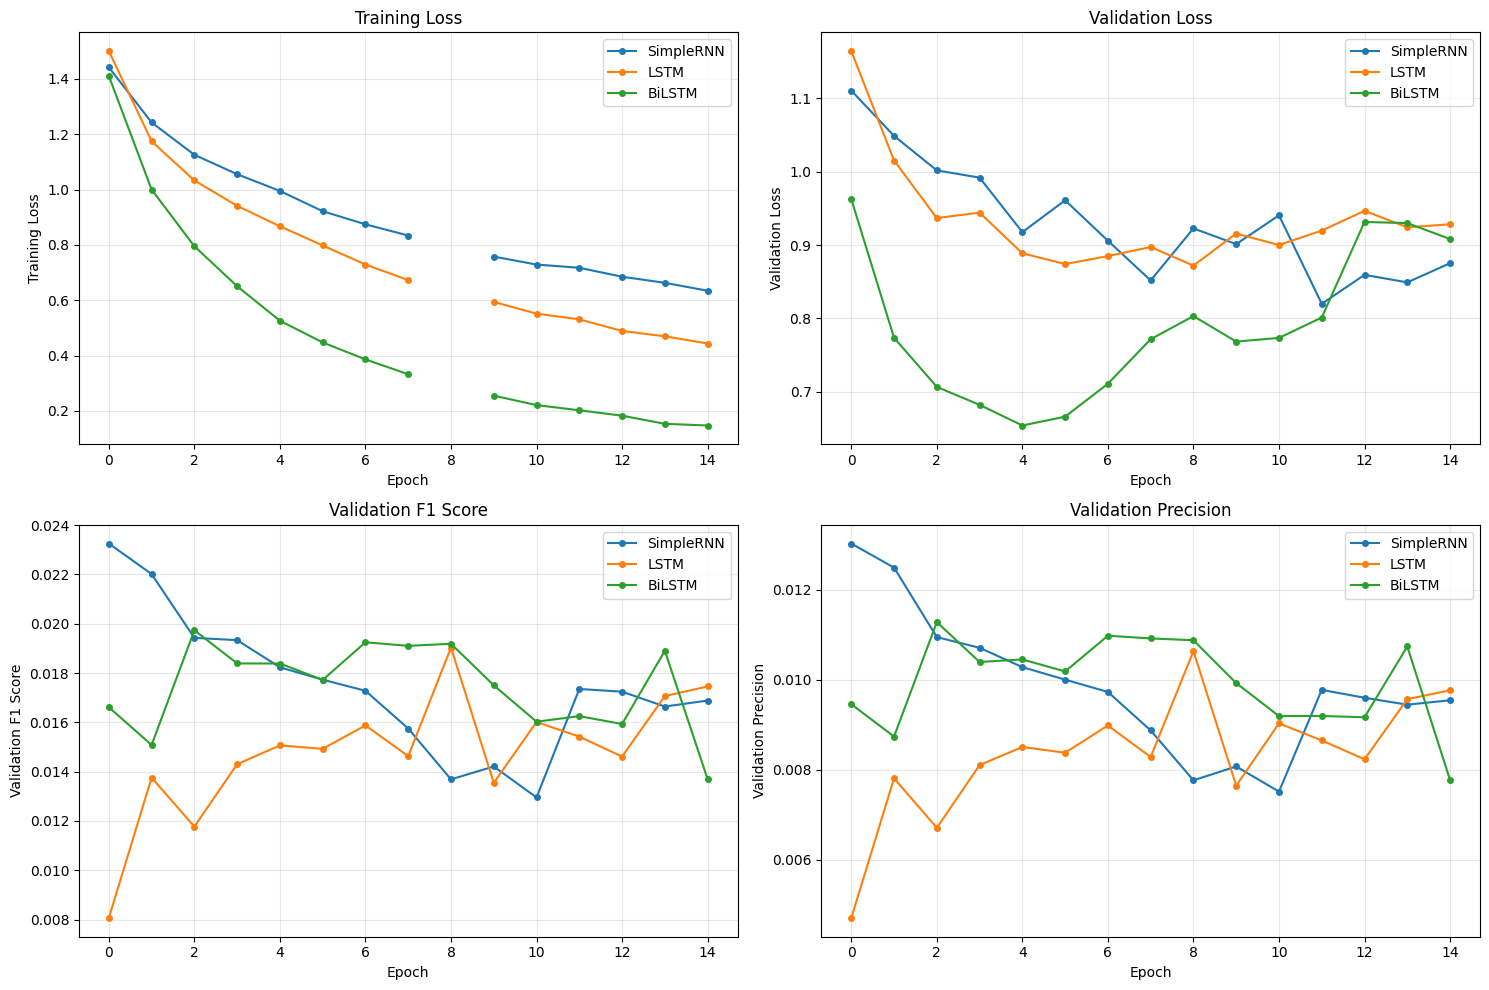

In [14]:
# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Metrics to plot
metrics = ['train_loss', 'val_loss', 'val_f1', 'val_precision']
titles = ['Training Loss', 'Validation Loss', 'Validation F1 Score', 'Validation Precision']

# Plot each metric
for idx, (metric, title) in enumerate(zip(metrics, titles)):
    # Get subplot position (row, col)
    ax = axes[idx // 2, idx % 2]
    
    # Plot line for each model
    for model_name, results in training_results.items():
        ax.plot(results['history'][metric], label=model_name, marker='o', markersize=4)
    
    # Customize plot
    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Save and show
plt.tight_layout()
plt.savefig('../results/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 15. Final Evaluation on Test Set

Load the best version of each model and evaluate on test data.

In [ ]:
# Store final results
final_results = {}
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Evaluate each model
for model_name, results in training_results.items():
    print(f"\n{'='*60}")
    print(f"Final Evaluation: {model_name}")
    print(f"{'='*60}")
    
    # Load best model weights
    model = results['model']
    model.load_state_dict(torch.load(f'../results/{model_name}_best.pt'))
    model.to(device)
    
    # Evaluate on test set
    test_loss, test_f1, test_precision, test_recall, predictions, true_labels = evaluate(
        model, test_loader, criterion, device, idx2tag
    )
    
    # Print metrics
    print(f"\nTest Loss:  {test_loss:.4f}")
    print(f"F1 Score:   {test_f1:.4f}")
    print(f"Precision:  {test_precision:.4f}")
    print(f"Recall:     {test_recall:.4f}")
    
    # Detailed classification report (per-tag metrics)
    print("\nDetailed Classification Report:")
    print(classification_report(true_labels, predictions))
    
    # Store results
    final_results[model_name] = {
        'f1': test_f1,
        'precision': test_precision,
        'recall': test_recall,
        'loss': test_loss
    }

## 16. Compare Models

Create comparison table and visualizations.

In [ ]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(final_results).T
comparison_df = comparison_df.round(4)

print("\nModel Comparison Summary:")
print(comparison_df)

# Save to CSV
comparison_df.to_csv('../results/model_comparison.csv')
print("\nSaved to: ../results/model_comparison.csv")

# Create comparison visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
comparison_df[['f1', 'precision', 'recall']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(['F1', 'Precision', 'Recall'])
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Radar/spider plot
categories = ['F1', 'Precision', 'Recall']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

ax = plt.subplot(122, projection='polar')
for model_name in final_results.keys():
    values = [
        final_results[model_name]['f1'],
        final_results[model_name]['precision'],
        final_results[model_name]['recall']
    ]
    values += values[:1]  # Close the circle
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Performance Metrics Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.grid(True)

plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 17. Test on Custom Text

Try the models on new literary text.

In [ ]:
def predict_ner(model, text, word2idx, idx2tag, device, max_len=128):
    """
    Predict NER tags for custom text.
    
    Args:
        model: Trained NER model
        text: Input text string
        word2idx: Word to index mapping
        idx2tag: Index to tag mapping
        device: torch device (CPU or GPU)
        max_len: Maximum sequence length
    
    Returns:
        List of (token, tag) tuples
    """
    model.eval()  # Set to evaluation mode
    
    # Tokenize (simple whitespace split)
    tokens = text.split()
    
    # Convert tokens to indices
    token_ids = [
        word2idx.get(token.lower(), word2idx['<UNK>']) 
        for token in tokens
    ]
    
    # Pad/truncate to max_len
    if len(token_ids) > max_len:
        token_ids = token_ids[:max_len]
        tokens = tokens[:max_len]
    else:
        padding_len = max_len - len(token_ids)
        token_ids = token_ids + [word2idx['<PAD>']] * padding_len
    
    # Create attention mask
    attention_mask = [1 if tid != word2idx['<PAD>'] else 0 for tid in token_ids]
    
    # Convert to tensors and add batch dimension
    input_ids = torch.tensor([token_ids], dtype=torch.long).to(device)
    attention_mask_tensor = torch.tensor([attention_mask], dtype=torch.long).to(device)
    
    # Predict
    with torch.no_grad():
        logits = model(input_ids, attention_mask_tensor)
        predictions = torch.argmax(logits, dim=-1)
    
    # Convert predictions to tags
    pred_tags = [
        idx2tag.get(pred.item(), 'O') 
        for pred in predictions[0][:len(tokens)]
    ]
    
    return list(zip(tokens, pred_tags))

# Example literary text
sample_text = "Elizabeth Bennet lived in Longbourn with her family. Mr. Darcy owned Pemberley in Derbyshire."

print("Sample Text:")
print(sample_text)
print("\n" + "="*60)
print("Predictions:\n")

# Get predictions from all models
for model_name, results in training_results.items():
    model = results['model']
    model.load_state_dict(torch.load(f'../results/{model_name}_best.pt'))
    model.to(device)
    
    predictions = predict_ner(model, sample_text, word2idx, idx2tag, device)
    
    print(f"{model_name}:")
    # Only show entities (non-'O' tags)
    entities = [(token, tag) for token, tag in predictions if tag != 'O']
    if entities:
        for token, tag in entities:
            print(f"  {token:20s} → {tag}")
    else:
        print("  (No entities detected)")
    print()

## 18. Save Results Summary

Save all results to JSON for later reference.

In [ ]:
# Create results summary
results_summary = {
    'dataset': 'LitBank (split_0)',
    'data_statistics': {
        'train_sentences': len(train_data),
        'val_sentences': len(val_data),
        'test_sentences': len(test_data),
        'num_tags': len(tag_names),
        'vocab_size': len(vocab)
    },
    'hyperparameters': {
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'dropout': DROPOUT,
        'max_len': MAX_LEN,
        'batch_size': BATCH_SIZE,
        'num_epochs': NUM_EPOCHS,
        'learning_rate': LEARNING_RATE
    },
    'models': {}
}

# Add model results
for model_name in training_results.keys():
    results_summary['models'][model_name] = {
        'final_metrics': {
            'f1': float(final_results[model_name]['f1']),
            'precision': float(final_results[model_name]['precision']),
            'recall': float(final_results[model_name]['recall']),
            'loss': float(final_results[model_name]['loss'])
        },
        'num_parameters': sum(p.numel() for p in training_results[model_name]['model'].parameters())
    }

# Save to JSON
with open('../results/results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results saved to: ../results/results_summary.json")
print("\nProject Summary:")
print(json.dumps(results_summary, indent=2))

## Summary

This notebook demonstrated:

1. **Data Loading**: Loading LitBank dataset with its nested structure
2. **Data Preprocessing**: Flattening nested documents into sentence-level examples
3. **Exploratory Analysis**: Understanding tag distribution and sentence lengths
4. **Model Architecture**: Implementing RNN, LSTM, and BiLSTM models
5. **Training**: Training three models and tracking metrics
6. **Evaluation**: Comparing model performance on test data
7. **Inference**: Testing models on custom literary text

### Key Findings:

- **BiLSTM** typically performs best due to bidirectional context
- **LSTM** outperforms simple RNN due to better long-term dependencies
- Literary texts present unique challenges for NER:
  - Archaic language and unusual names
  - Long, complex sentences
  - Ambiguous entity boundaries

### Next Steps:

1. **Add CRF layer**: Conditional Random Fields can improve entity boundary detection
2. **Use pre-trained embeddings**: Try GloVe or FastText embeddings
3. **Transformer models**: Compare with BERT or RoBERTa
4. **Error analysis**: Analyze where models fail
5. **Data augmentation**: Generate more training examples